# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

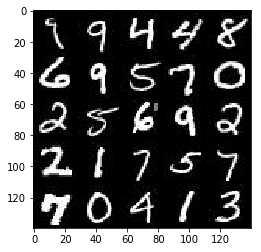

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

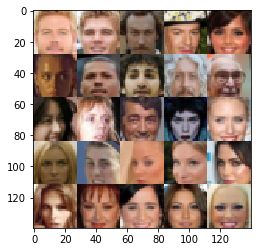

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (), name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [65]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # input: 28x28xchannels
        
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(conv1, training=True)
        relu1 = tf.maximum(alpha * conv1, conv1)
        # 14x14x64
        
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        conv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logit = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logit)

        return output, logit


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [66]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        fc1 = tf.layers.dense(z, 7 * 7 * 512)
        proj1 = tf.reshape(fc1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(proj1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 7x7x512
        
        deconv2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(deconv2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256
        
        deconv3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(deconv3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim
        
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [67]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    input_gen = generator(input_z, out_channel_dim)
    d_output_real, d_logit_real = discriminator(input_real)
    d_output_fake, d_logit_fake = discriminator(input_gen, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_real, labels=tf.ones_like(d_output_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake, labels=tf.zeros_like(d_output_fake)))

    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake, labels=tf.ones_like(d_output_fake)))

    return d_loss, g_loss    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [68]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [69]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [70]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    [_, image_width, image_height, image_channels] = data_shape
    input_real, input_z, _ = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1) 

    print_every = 10
    show_every = 100
    no_samples = 4
    
    i = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                i += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                sess.run(g_opt, feed_dict={input_z: batch_z})
                
                report_images = batch_images
                report_z = batch_z

                if i % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}\t".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}\t".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if i % show_every == 0:
                    show_generator_output(sess, no_samples, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2	 Discriminator Loss: 0.9851	 Generator Loss: 0.7242
Epoch 1/2	 Discriminator Loss: 0.6635	 Generator Loss: 1.1786
Epoch 1/2	 Discriminator Loss: 2.3000	 Generator Loss: 0.1956
Epoch 1/2	 Discriminator Loss: 1.9446	 Generator Loss: 0.4082
Epoch 1/2	 Discriminator Loss: 1.0706	 Generator Loss: 1.0357
Epoch 1/2	 Discriminator Loss: 0.9280	 Generator Loss: 1.1885
Epoch 1/2	 Discriminator Loss: 1.4079	 Generator Loss: 0.5444
Epoch 1/2	 Discriminator Loss: 0.9708	 Generator Loss: 0.7833
Epoch 1/2	 Discriminator Loss: 0.9661	 Generator Loss: 1.4086
Epoch 1/2	 Discriminator Loss: 1.0755	 Generator Loss: 0.6321


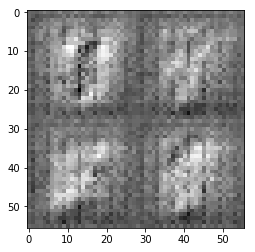

Epoch 1/2	 Discriminator Loss: 0.7846	 Generator Loss: 1.1535
Epoch 1/2	 Discriminator Loss: 0.6981	 Generator Loss: 1.8119
Epoch 1/2	 Discriminator Loss: 0.6369	 Generator Loss: 1.0239
Epoch 1/2	 Discriminator Loss: 0.4546	 Generator Loss: 1.6978
Epoch 1/2	 Discriminator Loss: 0.7357	 Generator Loss: 0.7752
Epoch 1/2	 Discriminator Loss: 0.4713	 Generator Loss: 1.3020
Epoch 1/2	 Discriminator Loss: 0.3803	 Generator Loss: 2.5767
Epoch 1/2	 Discriminator Loss: 0.8532	 Generator Loss: 3.5855
Epoch 1/2	 Discriminator Loss: 1.3959	 Generator Loss: 0.3323
Epoch 1/2	 Discriminator Loss: 1.2028	 Generator Loss: 0.4636


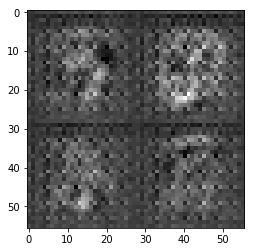

Epoch 1/2	 Discriminator Loss: 2.1947	 Generator Loss: 0.1464
Epoch 1/2	 Discriminator Loss: 1.5586	 Generator Loss: 0.4402
Epoch 1/2	 Discriminator Loss: 1.1144	 Generator Loss: 0.6429
Epoch 1/2	 Discriminator Loss: 1.1462	 Generator Loss: 0.6596
Epoch 1/2	 Discriminator Loss: 0.3655	 Generator Loss: 2.6874
Epoch 1/2	 Discriminator Loss: 0.8266	 Generator Loss: 2.2845
Epoch 1/2	 Discriminator Loss: 0.7078	 Generator Loss: 1.1218
Epoch 1/2	 Discriminator Loss: 0.4876	 Generator Loss: 1.2747
Epoch 1/2	 Discriminator Loss: 0.5133	 Generator Loss: 2.2336
Epoch 1/2	 Discriminator Loss: 0.4993	 Generator Loss: 1.4169


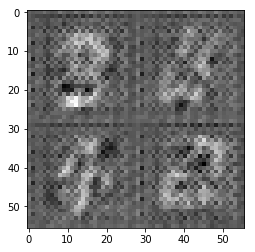

Epoch 1/2	 Discriminator Loss: 0.4111	 Generator Loss: 1.7052
Epoch 1/2	 Discriminator Loss: 0.4219	 Generator Loss: 1.5301
Epoch 1/2	 Discriminator Loss: 0.4765	 Generator Loss: 1.3769
Epoch 1/2	 Discriminator Loss: 0.4863	 Generator Loss: 1.3384
Epoch 1/2	 Discriminator Loss: 0.4555	 Generator Loss: 1.5028
Epoch 1/2	 Discriminator Loss: 0.4042	 Generator Loss: 2.5910
Epoch 1/2	 Discriminator Loss: 0.4096	 Generator Loss: 1.8158
Epoch 1/2	 Discriminator Loss: 0.3615	 Generator Loss: 2.2114
Epoch 1/2	 Discriminator Loss: 0.4424	 Generator Loss: 1.2954
Epoch 1/2	 Discriminator Loss: 0.4339	 Generator Loss: 1.3978


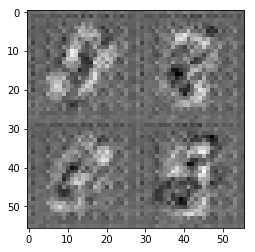

Epoch 1/2	 Discriminator Loss: 0.3226	 Generator Loss: 1.9096
Epoch 1/2	 Discriminator Loss: 0.3374	 Generator Loss: 1.8962
Epoch 1/2	 Discriminator Loss: 0.3292	 Generator Loss: 1.7316
Epoch 1/2	 Discriminator Loss: 0.2742	 Generator Loss: 2.1634
Epoch 1/2	 Discriminator Loss: 0.2514	 Generator Loss: 2.1729
Epoch 1/2	 Discriminator Loss: 0.5722	 Generator Loss: 3.4527
Epoch 2/2	 Discriminator Loss: 0.4651	 Generator Loss: 3.3186
Epoch 2/2	 Discriminator Loss: 0.2648	 Generator Loss: 2.1383
Epoch 2/2	 Discriminator Loss: 0.3001	 Generator Loss: 2.1512
Epoch 2/2	 Discriminator Loss: 1.1268	 Generator Loss: 0.4853


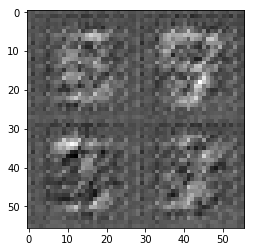

Epoch 2/2	 Discriminator Loss: 0.3233	 Generator Loss: 2.1058
Epoch 2/2	 Discriminator Loss: 0.2731	 Generator Loss: 2.2000
Epoch 2/2	 Discriminator Loss: 0.2819	 Generator Loss: 1.9886
Epoch 2/2	 Discriminator Loss: 0.2797	 Generator Loss: 2.2399
Epoch 2/2	 Discriminator Loss: 0.2581	 Generator Loss: 2.5996
Epoch 2/2	 Discriminator Loss: 0.2135	 Generator Loss: 2.2887
Epoch 2/2	 Discriminator Loss: 1.1245	 Generator Loss: 0.5903
Epoch 2/2	 Discriminator Loss: 0.2874	 Generator Loss: 2.1221
Epoch 2/2	 Discriminator Loss: 0.2672	 Generator Loss: 2.1265
Epoch 2/2	 Discriminator Loss: 0.2567	 Generator Loss: 2.1203


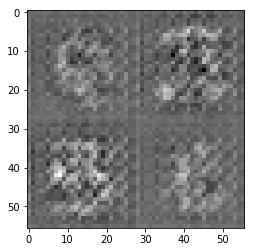

Epoch 2/2	 Discriminator Loss: 0.2238	 Generator Loss: 2.5546
Epoch 2/2	 Discriminator Loss: 0.2558	 Generator Loss: 2.0309
Epoch 2/2	 Discriminator Loss: 0.2084	 Generator Loss: 2.4244
Epoch 2/2	 Discriminator Loss: 1.1997	 Generator Loss: 5.2159
Epoch 2/2	 Discriminator Loss: 0.3513	 Generator Loss: 1.6754
Epoch 2/2	 Discriminator Loss: 0.2784	 Generator Loss: 2.0882
Epoch 2/2	 Discriminator Loss: 0.3300	 Generator Loss: 1.6696
Epoch 2/2	 Discriminator Loss: 0.1772	 Generator Loss: 2.7779
Epoch 2/2	 Discriminator Loss: 0.1742	 Generator Loss: 2.5972
Epoch 2/2	 Discriminator Loss: 0.1770	 Generator Loss: 2.6925


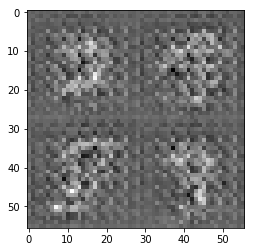

Epoch 2/2	 Discriminator Loss: 0.5522	 Generator Loss: 1.0340
Epoch 2/2	 Discriminator Loss: 0.2041	 Generator Loss: 2.3125
Epoch 2/2	 Discriminator Loss: 0.1991	 Generator Loss: 2.2384
Epoch 2/2	 Discriminator Loss: 0.3493	 Generator Loss: 1.8652
Epoch 2/2	 Discriminator Loss: 0.2522	 Generator Loss: 2.1720
Epoch 2/2	 Discriminator Loss: 0.2517	 Generator Loss: 2.0065
Epoch 2/2	 Discriminator Loss: 0.2258	 Generator Loss: 2.0849
Epoch 2/2	 Discriminator Loss: 0.2552	 Generator Loss: 1.9588
Epoch 2/2	 Discriminator Loss: 0.1741	 Generator Loss: 2.3165
Epoch 2/2	 Discriminator Loss: 0.1975	 Generator Loss: 2.3894


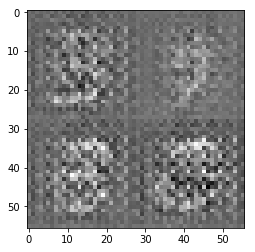

Epoch 2/2	 Discriminator Loss: 0.2232	 Generator Loss: 2.0160
Epoch 2/2	 Discriminator Loss: 0.1757	 Generator Loss: 2.4157
Epoch 2/2	 Discriminator Loss: 0.2691	 Generator Loss: 1.7971
Epoch 2/2	 Discriminator Loss: 0.6938	 Generator Loss: 3.8081
Epoch 2/2	 Discriminator Loss: 0.3559	 Generator Loss: 1.5173
Epoch 2/2	 Discriminator Loss: 0.3025	 Generator Loss: 1.7983
Epoch 2/2	 Discriminator Loss: 0.2506	 Generator Loss: 1.9883
Epoch 2/2	 Discriminator Loss: 0.2404	 Generator Loss: 2.0949
Epoch 2/2	 Discriminator Loss: 0.2384	 Generator Loss: 1.8876
Epoch 2/2	 Discriminator Loss: 0.2125	 Generator Loss: 2.0528


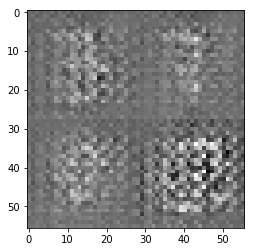

Epoch 2/2	 Discriminator Loss: 0.2033	 Generator Loss: 2.7218
Epoch 2/2	 Discriminator Loss: 0.1722	 Generator Loss: 2.3043
Epoch 2/2	 Discriminator Loss: 0.2729	 Generator Loss: 1.8333


In [71]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1	 Discriminator Loss: 1.8755	 Generator Loss: 0.3723
Epoch 1/1	 Discriminator Loss: 1.3984	 Generator Loss: 0.5640
Epoch 1/1	 Discriminator Loss: 0.9215	 Generator Loss: 0.9601
Epoch 1/1	 Discriminator Loss: 0.6765	 Generator Loss: 1.3064
Epoch 1/1	 Discriminator Loss: 0.8022	 Generator Loss: 1.2339
Epoch 1/1	 Discriminator Loss: 0.6003	 Generator Loss: 1.8363
Epoch 1/1	 Discriminator Loss: 0.4945	 Generator Loss: 1.7825
Epoch 1/1	 Discriminator Loss: 0.5841	 Generator Loss: 2.0528
Epoch 1/1	 Discriminator Loss: 0.5985	 Generator Loss: 1.5260
Epoch 1/1	 Discriminator Loss: 0.4659	 Generator Loss: 2.1362


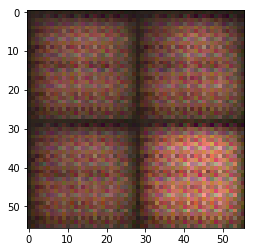

Epoch 1/1	 Discriminator Loss: 0.5461	 Generator Loss: 1.9976
Epoch 1/1	 Discriminator Loss: 0.3858	 Generator Loss: 1.7815
Epoch 1/1	 Discriminator Loss: 0.4261	 Generator Loss: 1.6953
Epoch 1/1	 Discriminator Loss: 0.3154	 Generator Loss: 1.8089
Epoch 1/1	 Discriminator Loss: 0.3330	 Generator Loss: 1.8926
Epoch 1/1	 Discriminator Loss: 0.2583	 Generator Loss: 2.0096
Epoch 1/1	 Discriminator Loss: 0.3143	 Generator Loss: 2.1508
Epoch 1/1	 Discriminator Loss: 0.1955	 Generator Loss: 3.1705
Epoch 1/1	 Discriminator Loss: 0.4488	 Generator Loss: 2.1530
Epoch 1/1	 Discriminator Loss: 0.3111	 Generator Loss: 4.3172


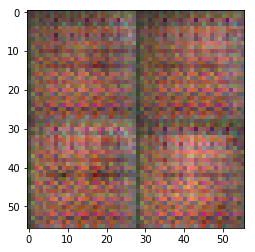

Epoch 1/1	 Discriminator Loss: 0.9584	 Generator Loss: 0.8108
Epoch 1/1	 Discriminator Loss: 0.2918	 Generator Loss: 2.4134
Epoch 1/1	 Discriminator Loss: 0.4833	 Generator Loss: 3.3589
Epoch 1/1	 Discriminator Loss: 1.2834	 Generator Loss: 1.6086
Epoch 1/1	 Discriminator Loss: 1.0713	 Generator Loss: 2.2850
Epoch 1/1	 Discriminator Loss: 0.4814	 Generator Loss: 3.0914
Epoch 1/1	 Discriminator Loss: 0.7307	 Generator Loss: 0.9653
Epoch 1/1	 Discriminator Loss: 1.4129	 Generator Loss: 0.4581
Epoch 1/1	 Discriminator Loss: 0.8791	 Generator Loss: 0.9318
Epoch 1/1	 Discriminator Loss: 0.7047	 Generator Loss: 1.4551


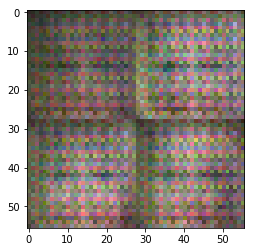

Epoch 1/1	 Discriminator Loss: 0.4699	 Generator Loss: 1.7912
Epoch 1/1	 Discriminator Loss: 0.4756	 Generator Loss: 1.6529
Epoch 1/1	 Discriminator Loss: 1.7783	 Generator Loss: 0.2613
Epoch 1/1	 Discriminator Loss: 1.2879	 Generator Loss: 0.4651
Epoch 1/1	 Discriminator Loss: 0.6040	 Generator Loss: 3.7046
Epoch 1/1	 Discriminator Loss: 0.4988	 Generator Loss: 1.4061
Epoch 1/1	 Discriminator Loss: 0.4145	 Generator Loss: 2.2243
Epoch 1/1	 Discriminator Loss: 0.9181	 Generator Loss: 0.7638
Epoch 1/1	 Discriminator Loss: 0.3925	 Generator Loss: 7.0764
Epoch 1/1	 Discriminator Loss: 0.6533	 Generator Loss: 0.9579


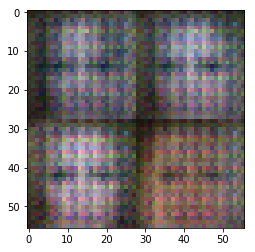

Epoch 1/1	 Discriminator Loss: 0.3712	 Generator Loss: 5.1546
Epoch 1/1	 Discriminator Loss: 0.6000	 Generator Loss: 5.6748
Epoch 1/1	 Discriminator Loss: 0.3675	 Generator Loss: 10.1905
Epoch 1/1	 Discriminator Loss: 0.3324	 Generator Loss: 2.4120
Epoch 1/1	 Discriminator Loss: 0.3199	 Generator Loss: 3.9568
Epoch 1/1	 Discriminator Loss: 0.4180	 Generator Loss: 5.4041
Epoch 1/1	 Discriminator Loss: 0.2825	 Generator Loss: 7.0558
Epoch 1/1	 Discriminator Loss: 0.2983	 Generator Loss: 6.8213
Epoch 1/1	 Discriminator Loss: 0.6104	 Generator Loss: 0.9879
Epoch 1/1	 Discriminator Loss: 0.2179	 Generator Loss: 4.1395


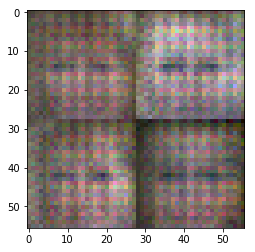

Epoch 1/1	 Discriminator Loss: 0.2713	 Generator Loss: 4.1142
Epoch 1/1	 Discriminator Loss: 0.2357	 Generator Loss: 6.1199
Epoch 1/1	 Discriminator Loss: 0.0637	 Generator Loss: 6.9781
Epoch 1/1	 Discriminator Loss: 0.2043	 Generator Loss: 4.0956
Epoch 1/1	 Discriminator Loss: 0.2521	 Generator Loss: 7.1642
Epoch 1/1	 Discriminator Loss: 0.6025	 Generator Loss: 1.1954
Epoch 1/1	 Discriminator Loss: 0.6856	 Generator Loss: 0.8745
Epoch 1/1	 Discriminator Loss: 0.1889	 Generator Loss: 6.2103
Epoch 1/1	 Discriminator Loss: 0.2108	 Generator Loss: 2.7258
Epoch 1/1	 Discriminator Loss: 0.1711	 Generator Loss: 2.5649


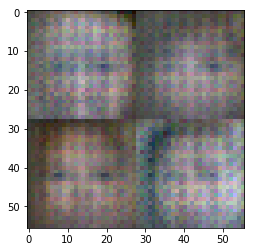

Epoch 1/1	 Discriminator Loss: 0.7288	 Generator Loss: 5.9811
Epoch 1/1	 Discriminator Loss: 1.8499	 Generator Loss: 0.2099
Epoch 1/1	 Discriminator Loss: 0.1135	 Generator Loss: 4.0589
Epoch 1/1	 Discriminator Loss: 0.0729	 Generator Loss: 4.9808
Epoch 1/1	 Discriminator Loss: 0.3695	 Generator Loss: 1.9211
Epoch 1/1	 Discriminator Loss: 1.4774	 Generator Loss: 7.6546
Epoch 1/1	 Discriminator Loss: 1.0442	 Generator Loss: 0.5996
Epoch 1/1	 Discriminator Loss: 0.0716	 Generator Loss: 9.9457
Epoch 1/1	 Discriminator Loss: 0.1777	 Generator Loss: 4.1466
Epoch 1/1	 Discriminator Loss: 0.0800	 Generator Loss: 4.3348


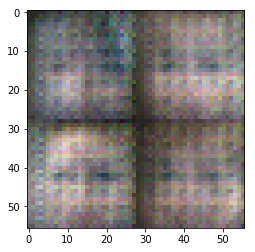

Epoch 1/1	 Discriminator Loss: 0.4428	 Generator Loss: 1.2538
Epoch 1/1	 Discriminator Loss: 0.1037	 Generator Loss: 2.9746
Epoch 1/1	 Discriminator Loss: 0.4894	 Generator Loss: 1.1726
Epoch 1/1	 Discriminator Loss: 0.0964	 Generator Loss: 3.0804
Epoch 1/1	 Discriminator Loss: 0.0840	 Generator Loss: 7.9329
Epoch 1/1	 Discriminator Loss: 1.6226	 Generator Loss: 8.9348
Epoch 1/1	 Discriminator Loss: 0.2802	 Generator Loss: 10.2493
Epoch 1/1	 Discriminator Loss: 0.1380	 Generator Loss: 2.6673
Epoch 1/1	 Discriminator Loss: 0.1151	 Generator Loss: 2.7698
Epoch 1/1	 Discriminator Loss: 1.1725	 Generator Loss: 8.6848


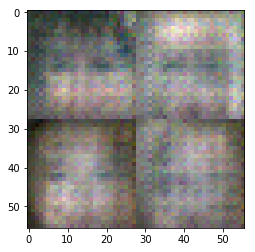

Epoch 1/1	 Discriminator Loss: 0.0395	 Generator Loss: 4.6488
Epoch 1/1	 Discriminator Loss: 0.0891	 Generator Loss: 3.6411
Epoch 1/1	 Discriminator Loss: 0.1727	 Generator Loss: 2.9209
Epoch 1/1	 Discriminator Loss: 0.1423	 Generator Loss: 2.6742
Epoch 1/1	 Discriminator Loss: 0.0795	 Generator Loss: 6.7385
Epoch 1/1	 Discriminator Loss: 0.1402	 Generator Loss: 2.4826
Epoch 1/1	 Discriminator Loss: 0.0708	 Generator Loss: 5.2947
Epoch 1/1	 Discriminator Loss: 0.0516	 Generator Loss: 7.2915
Epoch 1/1	 Discriminator Loss: 0.0424	 Generator Loss: 7.8009
Epoch 1/1	 Discriminator Loss: 0.4292	 Generator Loss: 1.5331


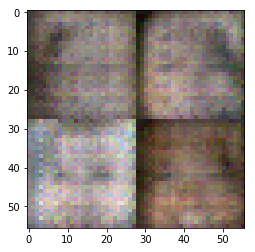

Epoch 1/1	 Discriminator Loss: 0.1474	 Generator Loss: 7.6480
Epoch 1/1	 Discriminator Loss: 0.8480	 Generator Loss: 8.1449
Epoch 1/1	 Discriminator Loss: 0.5553	 Generator Loss: 13.4539
Epoch 1/1	 Discriminator Loss: 0.5673	 Generator Loss: 9.2307
Epoch 1/1	 Discriminator Loss: 0.1957	 Generator Loss: 2.2405
Epoch 1/1	 Discriminator Loss: 0.3037	 Generator Loss: 11.7889
Epoch 1/1	 Discriminator Loss: 0.1662	 Generator Loss: 11.1108
Epoch 1/1	 Discriminator Loss: 0.0307	 Generator Loss: 10.0884
Epoch 1/1	 Discriminator Loss: 0.3337	 Generator Loss: 1.5252
Epoch 1/1	 Discriminator Loss: 0.0371	 Generator Loss: 8.6144


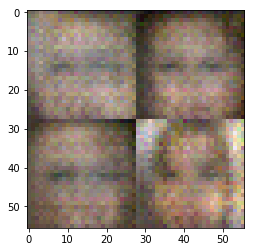

Epoch 1/1	 Discriminator Loss: 0.0483	 Generator Loss: 3.7067
Epoch 1/1	 Discriminator Loss: 0.0348	 Generator Loss: 6.7457
Epoch 1/1	 Discriminator Loss: 0.0311	 Generator Loss: 5.7341
Epoch 1/1	 Discriminator Loss: 0.5165	 Generator Loss: 1.0318
Epoch 1/1	 Discriminator Loss: 0.2594	 Generator Loss: 1.6956
Epoch 1/1	 Discriminator Loss: 0.0255	 Generator Loss: 5.9227
Epoch 1/1	 Discriminator Loss: 0.0334	 Generator Loss: 5.4545
Epoch 1/1	 Discriminator Loss: 0.0894	 Generator Loss: 6.0187
Epoch 1/1	 Discriminator Loss: 0.2437	 Generator Loss: 10.8359
Epoch 1/1	 Discriminator Loss: 0.1668	 Generator Loss: 2.2085


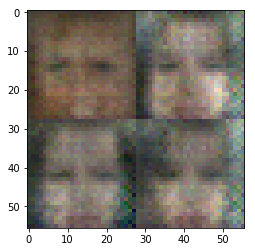

Epoch 1/1	 Discriminator Loss: 0.0519	 Generator Loss: 3.6790
Epoch 1/1	 Discriminator Loss: 0.0253	 Generator Loss: 7.8751
Epoch 1/1	 Discriminator Loss: 0.1285	 Generator Loss: 7.9006
Epoch 1/1	 Discriminator Loss: 0.1513	 Generator Loss: 2.3761
Epoch 1/1	 Discriminator Loss: 0.0281	 Generator Loss: 5.3930
Epoch 1/1	 Discriminator Loss: 0.0815	 Generator Loss: 3.4166
Epoch 1/1	 Discriminator Loss: 0.0660	 Generator Loss: 6.3007
Epoch 1/1	 Discriminator Loss: 0.0380	 Generator Loss: 8.1780
Epoch 1/1	 Discriminator Loss: 0.0498	 Generator Loss: 9.9583
Epoch 1/1	 Discriminator Loss: 0.1314	 Generator Loss: 6.5722


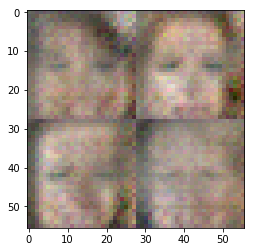

Epoch 1/1	 Discriminator Loss: 1.1996	 Generator Loss: 5.8609
Epoch 1/1	 Discriminator Loss: 0.0974	 Generator Loss: 5.8579
Epoch 1/1	 Discriminator Loss: 0.0419	 Generator Loss: 6.6479
Epoch 1/1	 Discriminator Loss: 0.0461	 Generator Loss: 5.3642
Epoch 1/1	 Discriminator Loss: 0.5927	 Generator Loss: 1.0411
Epoch 1/1	 Discriminator Loss: 0.1389	 Generator Loss: 2.4686
Epoch 1/1	 Discriminator Loss: 0.0777	 Generator Loss: 3.8501
Epoch 1/1	 Discriminator Loss: 0.0767	 Generator Loss: 8.8399
Epoch 1/1	 Discriminator Loss: 0.3624	 Generator Loss: 1.4529
Epoch 1/1	 Discriminator Loss: 0.6219	 Generator Loss: 1.0314


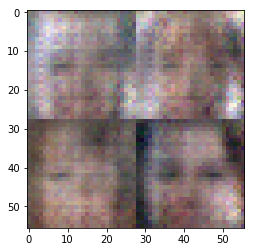

Epoch 1/1	 Discriminator Loss: 0.0625	 Generator Loss: 10.6810
Epoch 1/1	 Discriminator Loss: 0.0480	 Generator Loss: 6.9669
Epoch 1/1	 Discriminator Loss: 0.0800	 Generator Loss: 3.7505
Epoch 1/1	 Discriminator Loss: 0.1350	 Generator Loss: 9.4644
Epoch 1/1	 Discriminator Loss: 0.0135	 Generator Loss: 10.5650
Epoch 1/1	 Discriminator Loss: 0.0177	 Generator Loss: 5.8124
Epoch 1/1	 Discriminator Loss: 0.0176	 Generator Loss: 8.6561
Epoch 1/1	 Discriminator Loss: 0.0205	 Generator Loss: 10.4151
Epoch 1/1	 Discriminator Loss: 0.0384	 Generator Loss: 4.8291
Epoch 1/1	 Discriminator Loss: 0.0182	 Generator Loss: 10.4147


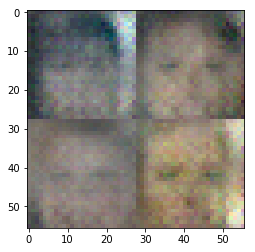

Epoch 1/1	 Discriminator Loss: 0.1453	 Generator Loss: 11.7330
Epoch 1/1	 Discriminator Loss: 0.1979	 Generator Loss: 2.0172
Epoch 1/1	 Discriminator Loss: 0.1193	 Generator Loss: 10.4329
Epoch 1/1	 Discriminator Loss: 0.0707	 Generator Loss: 13.4370
Epoch 1/1	 Discriminator Loss: 0.1955	 Generator Loss: 2.2559
Epoch 1/1	 Discriminator Loss: 0.0366	 Generator Loss: 7.8283
Epoch 1/1	 Discriminator Loss: 0.0506	 Generator Loss: 7.1333
Epoch 1/1	 Discriminator Loss: 0.0687	 Generator Loss: 5.6732
Epoch 1/1	 Discriminator Loss: 0.0220	 Generator Loss: 11.1877
Epoch 1/1	 Discriminator Loss: 0.0929	 Generator Loss: 14.1640


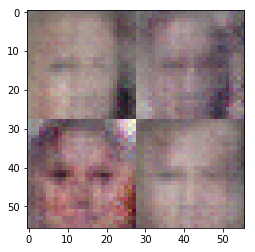

Epoch 1/1	 Discriminator Loss: 0.0126	 Generator Loss: 10.2326
Epoch 1/1	 Discriminator Loss: 0.2170	 Generator Loss: 1.9624
Epoch 1/1	 Discriminator Loss: 0.0067	 Generator Loss: 10.4981
Epoch 1/1	 Discriminator Loss: 0.0536	 Generator Loss: 8.0432
Epoch 1/1	 Discriminator Loss: 0.0198	 Generator Loss: 4.4490
Epoch 1/1	 Discriminator Loss: 0.5927	 Generator Loss: 1.0814
Epoch 1/1	 Discriminator Loss: 0.0163	 Generator Loss: 9.3546
Epoch 1/1	 Discriminator Loss: 0.2415	 Generator Loss: 2.2281


In [73]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.